Anita Graser's example: https://plugins.qgis.org/planet/tag/jupyter/

In [1]:
use_case = {'ComputerName': 'Calculon'}  #Replace with 'Alice' or 'Selene' as required  

## Introduction

The goals 
- Have an easily managed collection of packages through Conda, 
- Including the basic functionality of QGIS, 
- Using specified version of both QGIS and Python
- **And** any extra functionality avaliable from QGIS plugins.  Especially the main providers, like Processing, SAGA & GRASS, 
- Potentially also custom plugins, which can be installed easily into a single base QGIS version for the operating system.

These are all the Python paths I get from `sys.path` inside QGIS console (on Linux):  

`['/usr/share/qgis/python', '/home/olly/.local/share/QGIS/QGIS3/profiles/default/python', '/home/olly/.local/share/QGIS/QGIS3/profiles/default/python/plugins', '/usr/share/qgis/python/plugins', '/usr/lib/python3.10', '/usr/lib/python3/dist-packages',  '/home/olly/.local/share/QGIS/QGIS3/profiles/default/python']`  

It's a little different on Windows, since it Windows QGIS packs with its own Python Interpreter.  Note that on Linux the packags are sitting with the system default Python interpreter.  If we run `sys.path`, & `sys.version` we get:

- `/usr/bin/python3`
- `3.12.3 (main, Sep 11 2024, 14:17:37) [GCC 13.2.0]`

From all this we need the plugins, so that we can manage QGIS plugins using QGIS plugin installation processes 
whilst accessing them for our Python work.  And also any dynamic links from `LD_LIBRARY_PATH` for any of those plugins that have C bindings.

To make this work:
1. Add the extra paths must be added to `PYTHONPATH`
2. `LD_LIBRARY_PATH` from the base QGIS install needs to be added to `LD_LIBRARY_PATH`
3. The IDE needs to know about the extra package paths, for Linting, Autocomplete, Analysis tools etc.
4. The Conda environment is activated in the usual way before the code is run.

To run a Python .py script using this environment from terminal outside of any IDE considerations, go to the folder holding the scripts and the .env, then:
1. `conda activate my_environment`  
2. `source .env`  (Setus up all the paths and stores in environment variables)
3. `my_test_script.py`   (Uses the interpreter from the .env to run the Python script)

### Imports
First let's try some QGIS imports.  I'm currently having trouble with VSCode's linting functionality here, but everything else seems to work.

In [2]:
import qgis
from qgis.gui import *
from qgis.gui import QgsGeographicCoordinateNumericFormatWidget #Just a random example
from qgis.core import *
from qgis.utils import plugins
from qgis.analysis import QgsNativeAlgorithms 
from PyQt5.QtCore import *
from PyQt5.QtWidgets import QApplication
from processing.core.Processing import processing

Now any other imports from Conda or standard Python

In [3]:
#Standard Python
import os, sys, time, warnings
from pathlib import Path

#Conda
from osgeo import gdal
import cv2
from PIL import Image
import piexif 
import matplotlib
import pandas as pd
import geopandas as gpd
import plotly.express as px
import seaborn as sns
import sklearn as skl
import scipy
import shapely
import cartopy
import folium
import geoviews
import dotenv
import arrow
import yaml
import fastparquet
import xmltodict
import rasterio    
import rasterstats
import contextily
import ipyleaflet

### Settings & Filepaths

In [4]:
if use_case['ComputerName'] =='Calculon':  #Windows
    project_path = Path("F:/Documents/GIS/Notebooks")
    qgis_prefix = 'C:/Program Files/QGIS 3.38.2'
elif use_case['ComputerName'] in ['Alice', 'Selene']:  #Linux
    project_path = Path("/media/olly/Blue Samsung SSD/Documents/GIS/Documents/GIS/Notebooks")
    qgis_prefix = '/usr'

working = project_path / 'Working'
data = project_path / 'Data'
results = project_path / 'Results'

project_path = str(working / 'geo_test_project.qgz')
shapefile_path = str(data / 'kx-doc-huts-SHP/doc-huts.shp')
buffer_output_path = str(working / 'buffer.shp')

### QGIS Examples

In [5]:
QgsApplication.setPrefixPath(qgis_prefix, True)

In [6]:
#Something going on here, we can't seem to run this cell more than once without re-starting the kernel first.
#app = QgsApplication([], False)
app = QApplication([])
qgs = QgsApplication([], False)
qgs.initQgis()  
#app.exit()  # doesn't help


In [7]:
project = QgsProject.instance()
canvas = QgsMapCanvas()
#map_crs = QgsCoordinateReferenceSystem('EPSG:3857')
project.read(project_path)  
print(project.fileName())

F:/Documents/GIS/Notebooks/Working/geo_test_project.qgz


I'm not convinced there is much point opening an existing project  Wouldn't would be unusual to run a notebook on a partly processed project?  But it might be more likely to save out a project, then open in QGIS.  Or maybe this would be handy to automate some complicated part of a larger body of work without making it into a dedicated plugin?

Let's have a look at the processing registry now.

In [8]:
providers = QgsProviderRegistry.instance().providerList()
for i in range(0, len(providers), 6):
    print(providers[i:i+6])

['OAPIF', 'WFS', 'arcgisfeatureserver', 'arcgismapserver', 'arcgisvectortileservice', 'cesiumtiles']
['copc', 'delimitedtext', 'ept', 'gdal', 'gpx', 'mbtilesvectortiles']
['mdal', 'memory', 'mesh_memory', 'mssql', 'ogr', 'pdal']
['postgres', 'postgresraster', 'sensorthings', 'spatialite', 'tiledscene', 'vectortile']
['virtual', 'virtualraster', 'vpc', 'vtpkvectortiles', 'wcs', 'wms']
['xyzvectortiles']


In [9]:
QgsApplication.processingRegistry().addProvider(QgsNativeAlgorithms())
for idx, alg in enumerate(QgsApplication.processingRegistry().algorithms()):
    if idx <=5:
       print(alg.id(), "--->", alg.displayName())

native:addautoincrementalfield ---> Add autoincremental field
native:addfieldtoattributestable ---> Add field to attributes table
native:adduniquevalueindexfield ---> Add unique value index field
native:addxyfields ---> Add X/Y fields to layer
native:affinetransform ---> Affine transform
native:aggregate ---> Aggregate


Now try to demonstrate some actual processing of something, with the native processes

In [14]:
v_layer = QgsVectorLayer(shapefile_path, 'input_layer', 'ogr')  

if v_layer.isValid():
    project.addMapLayer(v_layer)
else:
    print("Layer failed to load!")
project.addMapLayer(v_layer)

processing.run("native:buffer", {
    'INPUT': v_layer,
    'DISTANCE': 100,
    'OUTPUT': buffer_output_path
})

project.write(project_path)
app.exit()

### Pure Python Geoprocessing
Let's try some familiar geo processing straight from Conda libraries too

<Axes: >

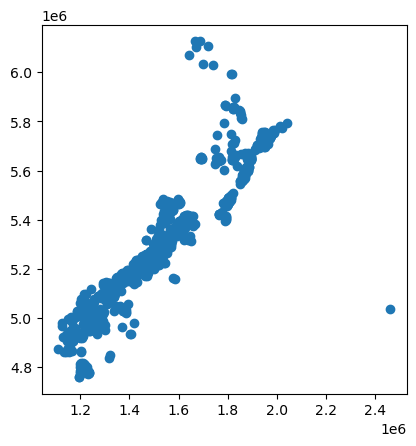

In [11]:
gdf = gpd.read_file(shapefile_path)
gdf.plot()

In [12]:
gdf.head(3)

,STATUS,DESCRIPTIO,CATEGORY_D,OBJECT_TYP,geometry
0,OPEN,Glenrae Hut,Buildings,Basic Hut/bivvy,POINT (1553678 5265191)
1,OPEN,Lake Alabaster Hut,Buildings,Serviced Hut,POINT (1214223 5055952)
2,OPEN,Steele Creek Hut,Buildings,Basic Hut/bivvy,POINT (1222335 5014107)


In [13]:
print('\033[1m' + '\033[94m' + "God damn it Gump you're goddamn genius. \n"
      "That's the most outstanding answer I've ever heard.\n"
      "You must have a goddam IQ of 160.\n"
      "You are goddam gifted private Gump." + '\033[0m')

God damn it Gump you're goddamn genius. 
That's the most outstanding answer I've ever heard.
You must have a goddam IQ of 160.
You are goddam gifted private Gump.
